In [4]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import re

import nltk
nltk.download('punkt')
nltk.download('gutenberg')
nltk.download('stopwords')
from nltk.corpus import gutenberg
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import spacy
stop_words = stopwords.words('english')
nlp = spacy.load('en_core_web_sm') 
nlp.disable_pipes('ner', 'parser')

import gensim.corpora as corpora
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import LdaModel, CoherenceModel
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Nmf

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from operator import itemgetter
from collections import Counter

[nltk_data] Downloading package punkt to /Users/Mansi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package gutenberg to /Users/Mansi/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/Mansi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/Mansi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to /Users/Mansi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
import spacy
stop_words = stopwords.words('english')
nlp = spacy.load('en_core_web_sm') 
nlp.disable_pipes('ner', 'parser')

['ner', 'parser']

In [7]:
df_jobs = pd.read_csv("/Users/Mansi/Documents/INF2209H/Project/Skills-Extraction-from-Data-Science-Job-Postings-main 2/data/linkedin_data_scientist.csv")
#df_jobs = df_jobs[:50]

In [8]:
df_jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   1000 non-null   int64  
 1   Name         1000 non-null   object 
 2   Company      999 non-null    object 
 3   State        947 non-null    object 
 4   City         1000 non-null   object 
 5   Salary       0 non-null      float64
 6   Location     1000 non-null   object 
 7   Url          1000 non-null   object 
 8   Description  1000 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 70.4+ KB


In [9]:
df_jobs = df_jobs.drop(columns = ['Unnamed: 0','Url','Salary'], axis =1)

In [10]:
df_jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         1000 non-null   object
 1   Company      999 non-null    object
 2   State        947 non-null    object
 3   City         1000 non-null   object
 4   Location     1000 non-null   object
 5   Description  1000 non-null   object
dtypes: object(6)
memory usage: 47.0+ KB


In [11]:
# get the wond count in each job description
df_jobs['word_count'] = df_jobs['Description'].map(lambda x: x.split()).str.len()

# Deleting rows where job_descriptions are less than 10 words
df_jobs = df_jobs[df_jobs['word_count']>10]

In [12]:
#average word count in chapter 
display(df_jobs['word_count'].describe())

count    1000.000000
mean      511.767000
std       252.247794
min        48.000000
25%       349.000000
50%       482.000000
75%       636.250000
max      1940.000000
Name: word_count, dtype: float64

In [13]:
# Plot a hist of the word counts
fig = plt.figure(figsize=(10,5))

plt.hist(
    df_jobs['word_count'],
    bins=20,
    color='steelblue',
    edgecolor='white', 
    linewidth=1.2
)

plt.title('Number of words in each job description', fontsize=14)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('No. of words in job description', fontsize=12)
plt.yticks(np.arange(0, 200, 20))
plt.xticks(np.arange(0, 2000, 200))

plt.show()

In [14]:
df_jobs['job_description_processed'] = \
df_jobs['Description'].map(lambda x: re.sub('[,\.!?]','',x))
df_jobs['job_description_processed'] = \
df_jobs['job_description_processed'].map(lambda x: x.lower())
df_jobs['job_description_processed'].head()

0    ['auto req id:' ' 207072br' 'job description' ...
1    ['now brewing – data scientist operations anal...
2    ['refer a friend' 'company description' 'mcdon...
3    ['who we are' ' fueled by a fundamental belief...
4    ['abbott is a global healthcare leader that he...
Name: job_description_processed, dtype: object

In [15]:
stop_words = stopwords.words('english')
stop_words.extend(['relate','also','general','take','applicant','standard','prefer','provide','perform','need','skill','base','application','datum','able','ability','new','must','provide','ensure','from', 'subject', 're', 'edu', 'use','require','seeking','position','years','job','including','required','opportunity','work','job','description','apply','needed','company','join','meet','area','order','look','include','contact','bring','direct','null'])
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc))
            if word not in stop_words] for doc in texts]

In [16]:
df_jobs_processed = df_jobs.job_description_processed.values.tolist()
df_jobs_words = list(sent_to_words(df_jobs_processed))
df_jobs_words_stopwords_removed = remove_stopwords(df_jobs_words)

In [17]:
word_list_all = [ item for elem in df_jobs_words_stopwords_removed for item in elem]
word_list_all

['auto',
 'req',
 'id',
 'br',
 'passion',
 'talent',
 'data',
 'science',
 'stage',
 'continue',
 'share',
 'future',
 'deliver',
 'innovative',
 'products',
 'delight',
 'consumers',
 'pepsico',
 'global',
 'data',
 'science',
 'analytics',
 'team',
 'focuses',
 'autonomous',
 'semi',
 'autonomous',
 'examination',
 'data',
 'content',
 'discover',
 'deep',
 'insights',
 'make',
 'predictions',
 'recommendations',
 'various',
 'techniques',
 'tools',
 'beyond',
 'traditional',
 'business',
 'intelligence',
 'ones',
 'major',
 'techniques',
 'expertise',
 'ml',
 'ai',
 'predictive',
 'modeling',
 'cognitive',
 'computing',
 'vision',
 'speech',
 'language',
 'analytics',
 'etc',
 'robotic',
 'process',
 'automation',
 'rpa',
 'support',
 'research',
 'development',
 'pepsico',
 'diverse',
 'portfolio',
 'beverages',
 'foods',
 'make',
 'business',
 'impact',
 'market',
 'success',
 'rewarding',
 'personal',
 'professional',
 'growth',
 'unique',
 'propel',
 'data',
 'science',
 'setti

In [18]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [19]:
data_lemmatized = lemmatization(df_jobs_words_stopwords_removed, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
data_lemmatized_all = [ item for elem in data_lemmatized for item in elem]

In [20]:
import matplotlib
from nltk.probability import FreqDist
matplotlib.use('TkAgg')

def plot_freq_dist(words, num_words = 40):
    fdist = FreqDist(words)
    fdist.plot(num_words, cumulative=False)

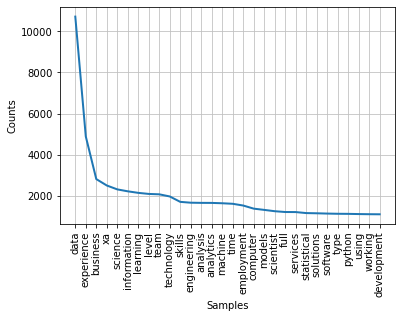

In [21]:
%matplotlib inline
plot_freq_dist(word_list_all,num_words=30)

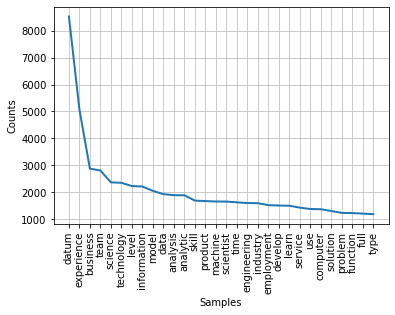

In [22]:
%matplotlib inline
plot_freq_dist(data_lemmatized_all,num_words=30)

In [23]:
# Get the top 20 most common words among all the articles
p_text = data_lemmatized

# Flaten the list of lists
p_text = [item for sublist in p_text for item in sublist]

# Top 20
top_20 = pd.DataFrame(
    Counter(p_text).most_common(20),
    columns=['word', 'frequency']
)

top_20

word  frequency
0         datum       8527
1    experience       5080
2      business       2876
3          team       2809
4       science       2368
5    technology       2352
6         level       2230
7   information       2214
8         model       2052
9          data       1931
10     analysis       1891
11     analytic       1888
12        skill       1692
13      product       1673
14      machine       1658
15    scientist       1654
16         time       1627
17  engineering       1600
18     industry       1595
19   employment       1523

In [ ]:
# Plot a bar chart for the top 20 most frequently occuring words
fig = plt.figure(figsize=(20,7))

g = sns.barplot(
    x='word',
    y='frequency',
    data=top_20,
    palette='GnBu_d'
)

g.set_xticklabels(
    g.get_xticklabels(),
    rotation=45,
    fontsize=14
)

plt.yticks(fontsize=14)
plt.xlabel('Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Top 20 Words', fontsize=17)


plt.show()


In [52]:
def bag_of_words(list_words):  
    dict_word_count = {}
    for word in list_words:
        if(word in dict_word_count):
            continue
        else:
            d = {word:list_words.count(word)}
            dict_word_count.update(d)
    return dict_word_count                      

In [53]:
#Calling bag_of_words(tw) function to extract a single bag of words of all lemmatized words
dict_word_bag = {}   #Dictionary that would contain all words with their counts

d = bag_of_words(data_lemmatized_all)
for key in d.keys():
    if key in dict_word_bag.keys():
        dict_word_bag[key] = dict_word_bag[key] + d[key]
    else:
        dict_word_bag.update({key:d[key]})

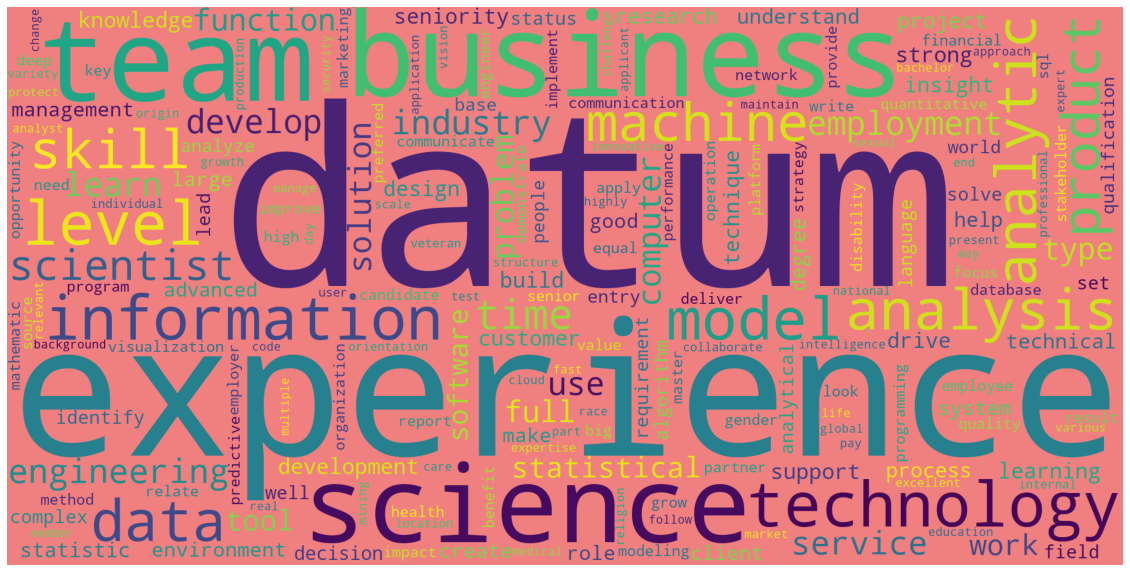

In [54]:
#Code block to generate word cloud 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='LightCoral', collocations=False).generate_from_frequencies(dict_word_bag)
plt.figure(figsize=(20, 15))
# Display image
plt.imshow(wordcloud) 
plt.axis("off");

In [24]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /Users/Mansi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Jaccard Similarity & Coherence in LDA-model using Gensim

In [25]:
# Function to calculate Jaccard similarity of two topics
def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics

    Jaccard similarity:
    - A statistic used for comparing the similarity and diversity of sample sets
    - J(A,B) = (A ∩ B)/(A ∪ B)
    - Goal is low Jaccard scores for coverage of the diverse elements
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))

In [26]:
id2word = corpora.Dictionary(data_lemmatized)
bow_corpus = [id2word.doc2bow(text) for text in data_lemmatized]

# Considering 1-50 topics with 15 keywords each
num_topics = list(range(15)[1:])
num_keywords = 10

LDA_models = {}
LDA_topics = {}
for i in num_topics:
    LDA_models[i] = LdaModel(corpus=bow_corpus,
                             id2word=id2word,
                             num_topics=i,
                             update_every=1,
                             chunksize=len(bow_corpus),
                             passes=20,
                             alpha='auto',
                             random_state=42)

    shown_topics = LDA_models[i].show_topics(num_topics=i, 
                                             num_words=num_keywords,
                                             formatted=False)
    LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]

In [27]:
# Derive mean stability across topics
LDA_stability = {}
for i in range(0, len(num_topics)-1):
    jaccard_sims = []
    for t1, topic1 in enumerate(LDA_topics[num_topics[i]]): # pylint: disable=unused-variable
        sims = []
        for t2, topic2 in enumerate(LDA_topics[num_topics[i+1]]): # pylint: disable=unused-variable
            sims.append(jaccard_similarity(topic1, topic2))    
        
        jaccard_sims.append(sims)    
    
    LDA_stability[num_topics[i]] = jaccard_sims
                
mean_stabilities = [np.array(LDA_stability[i]).mean() for i in num_topics[:-1]]

In [28]:
# Calculate Coherence
coherences = [CoherenceModel(model=LDA_models[i], texts=data_lemmatized, dictionary=id2word, coherence='c_v').get_coherence()\
                for i in num_topics[:-1]]

In [30]:
# Derive the ideal number of topics through the difference between coherence and stability per number of topics

coh_sta_diffs = [coherences[i] - mean_stabilities[i] for i in range(num_keywords)[:-1]] # limit topic numbers to the number of keywords
coh_sta_max = max(coh_sta_diffs)
coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
ideal_topic_num = num_topics[ideal_topic_num_index]

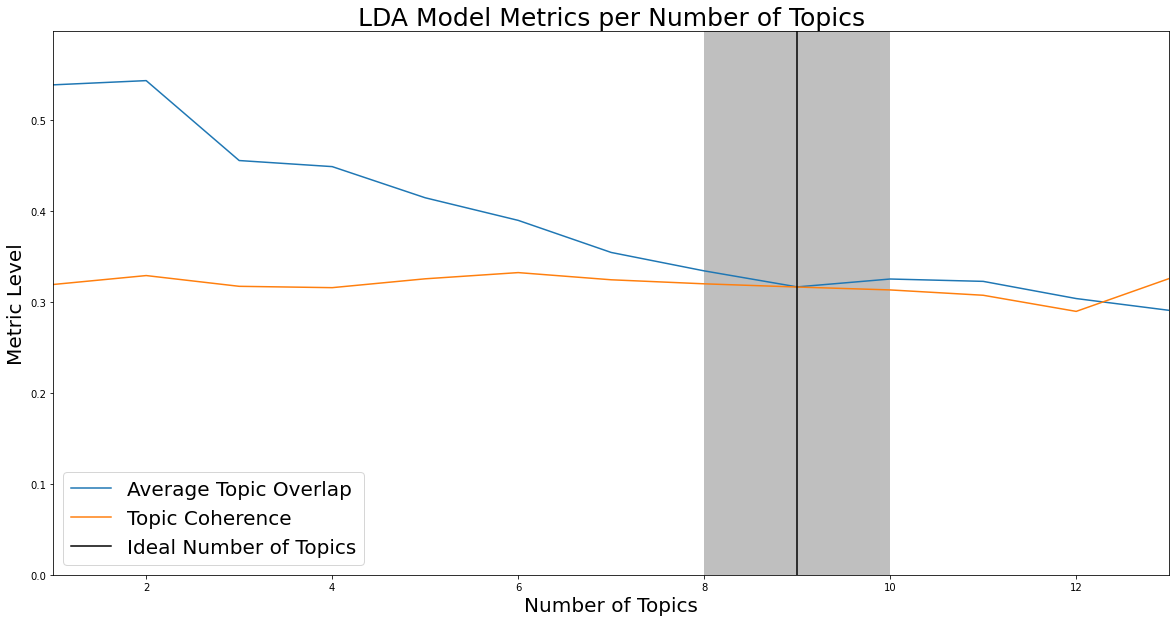

In [31]:
# Generating graphs of Jaccard Similarity, Coherence and Ideal Number of Topics 

plt.figure(figsize=(20,10))
ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Average Topic Overlap')
ax = sns.lineplot(x=num_topics[:-1], y=coherences, label='Topic Coherence')

ax.axvline(x=ideal_topic_num, label='Ideal Number of Topics', color='black')
ax.axvspan(xmin=ideal_topic_num - 1, xmax=ideal_topic_num + 1, alpha=0.5, facecolor='grey')

y_max = max(max(mean_stabilities), max(coherences)) + (0.10 * max(max(mean_stabilities), max(coherences)))
ax.set_ylim([0, y_max])
ax.set_xlim([1, num_topics[-1]-1])
                
ax.axes.set_title('LDA Model Metrics per Number of Topics', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=20)
plt.show()   

In [ ]:
# Jaccard Similarity and Coherence for ideal no. of topics identified above

## Jaccard Similarity & Coherence in NMF Model

In [45]:
num_topics = list(range(10)[1:])
coherence_scores = []

id2word = corpora.Dictionary(data_lemmatized)

# Filter out extremes to limit the number of features
id2word.filter_extremes(no_below=0.1, no_above=0.8, keep_n=5000)

# Create the bag-of-words format (list of (token_id, token_count))
bow_corpus = [id2word.doc2bow(text) for text in data_lemmatized]

nmf_models = {}
nmf_topics = {}

for i in num_topics:
    nmf_models[i] = Nmf(
      corpus=bow_corpus,
      num_topics=i,
      id2word=id2word,
      chunksize=2000,
      passes=10,
      kappa=.1,
      minimum_probability=0.01,
      w_max_iter=300,
      w_stop_condition=0.0001,
      h_max_iter=100,
      h_stop_condition=0.001,
      eval_every=10,
      normalize=True
  )
    shown_topics_nmf = nmf_models[i].show_topics(num_topics=i, 
                                             num_words=num_keywords,
                                             formatted=False)
    nmf_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]
    
# Derive mean stability across topics
NMF_stability = {}
for i in range(0, len(num_topics)-1):
    jaccard_sims = []
    for t1, topic1 in enumerate(nmf_topics[num_topics[i]]): # pylint: disable=unused-variable
        sims = []
        for t2, topic2 in enumerate(nmf_topics[num_topics[i+1]]): # pylint: disable=unused-variable
            sims.append(jaccard_similarity(topic1, topic2))    
        
        jaccard_sims.append(sims)    
    
    NMF_stability[num_topics[i]] = jaccard_sims
                
mean_stabilities_NMF = [np.array(NMF_stability[i]).mean() for i in num_topics[:-1]]



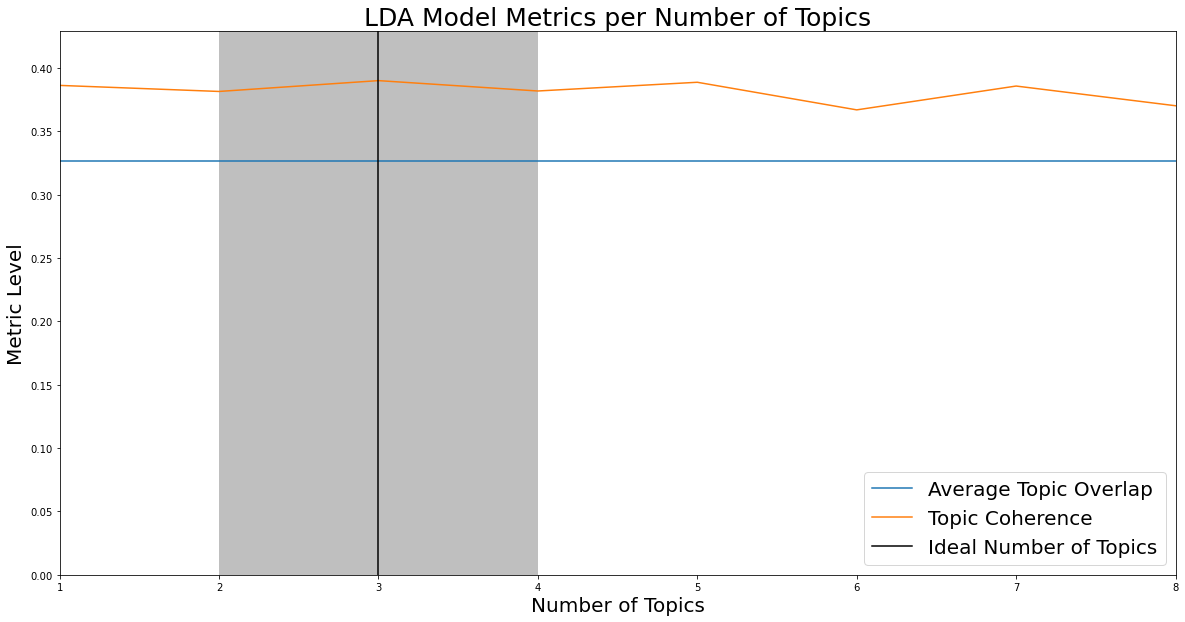

In [48]:
# Calculate Coherence
coherences_nmf = [CoherenceModel(model=nmf_models[i], texts=data_lemmatized, dictionary=id2word, coherence='c_v').get_coherence()\
                for i in num_topics[:-1]]

# Derive the ideal number of topics through the difference between coherence and stability per number of topics

coh_sta_diffs_NMF = [coherences_nmf[i] - mean_stabilities_NMF[i] for i in range(8)] # limit topic numbers to the number of keywords
coh_sta_max_NMF = max(coh_sta_diffs_NMF)
coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs_NMF) if j == coh_sta_max_NMF]
ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
ideal_topic_num_NMF = num_topics[ideal_topic_num_index]

# Generating graphs of Jaccard Similarity, Coherence and Ideal Number of Topics 

plt.figure(figsize=(20,10))
ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities_NMF, label='Average Topic Overlap')
ax = sns.lineplot(x=num_topics[:-1], y=coherences_nmf, label='Topic Coherence')

ax.axvline(x=ideal_topic_num_NMF, label='Ideal Number of Topics', color='black')
ax.axvspan(xmin=ideal_topic_num_NMF - 1, xmax=ideal_topic_num_NMF + 1, alpha=0.5, facecolor='grey')

y_max = max(max(mean_stabilities_NMF), max(coherences_nmf)) + (0.10 * max(max(mean_stabilities_NMF), max(coherences_nmf)))
ax.set_ylim([0, y_max])
ax.set_xlim([1, num_topics[-1]-1])
                
ax.axes.set_title('LDA Model Metrics per Number of Topics', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=20)
plt.show()   

### BTM ##

In [51]:
pip install biterm

  Using cached biterm-0.1.5.tar.gz (79 kB)
  Preparing metadata (setup.py) ... done
  ERROR: Command errored out with exit status 1:
   command: /Users/Mansi/opt/anaconda3/bin/python -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/kk/khf8gp2j1952n2txjlhr7wfc0000gn/T/pip-install-4933gk4l/biterm_4b2defb258d046858f4a004bdf798a2b/setup.py'"'"'; __file__='"'"'/private/var/folders/kk/khf8gp2j1952n2txjlhr7wfc0000gn/T/pip-install-4933gk4l/biterm_4b2defb258d046858f4a004bdf798a2b/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /private/var/folders/kk/khf8gp2j1952n2txjlhr7wfc0000gn/T/pip-wheel-3n9den5z
       cwd: /private/var/folders/kk/khf8gp2j1952n2txjlhr7wfc0000gn/T/pip-install-4933gk4l/biterm_4b2defb258d046858f4a004

Note: you may need to restart the kernel to use updated packages.


In [1]:
#BTM
import numpy as np
import bitermplus as btm
import tmplot as tmp
import pickle as pkl

ModuleNotFoundError: No module named 'bitermplus'

## Compare the models

In [ ]:
data = {'Algorithm':['LDA', 'NMF', 'BTM'],
        'Jaccard Similarity':[],
        'Coherence':[],
        'Perplexity':[],
        'Ideal No. of Topics':
       }
  
# Create DataFrame
df = pd.DataFrame(data)
  
# Print the output.
df

## LDA model for ideal no. of topics

In [57]:
id2word = corpora.Dictionary(data_lemmatized)
corpus = [id2word.doc2bow(text) for text in data_lemmatized]

from pprint import pprint

num_topics = 9

lda_model = gensim.models.LdaMulticore(corpus=corpus,id2word=id2word,num_topics=num_topics)

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.038*"datum" + 0.019*"experience" + 0.010*"team" + 0.009*"level" + '
  '0.009*"information" + 0.008*"technology" + 0.007*"model" + 0.007*"science" '
  '+ 0.006*"skill" + 0.006*"computer"'),
 (1,
  '0.019*"datum" + 0.016*"experience" + 0.011*"team" + 0.010*"business" + '
  '0.008*"data" + 0.007*"science" + 0.007*"technology" + 0.007*"level" + '
  '0.006*"skill" + 0.006*"analytic"'),
 (2,
  '0.033*"datum" + 0.020*"experience" + 0.013*"business" + 0.010*"science" + '
  '0.010*"team" + 0.008*"data" + 0.007*"level" + 0.007*"model" + '
  '0.006*"analysis" + 0.006*"scientist"'),
 (3,
  '0.032*"datum" + 0.017*"experience" + 0.011*"business" + 0.009*"analytic" + '
  '0.009*"model" + 0.009*"science" + 0.009*"machine" + 0.008*"team" + '
  '0.008*"information" + 0.008*"technology"'),
 (4,
  '0.028*"datum" + 0.015*"experience" + 0.011*"business" + 0.010*"team" + '
  '0.009*"technology" + 0.009*"level" + 0.008*"data" + 0.008*"science" + '
  '0.008*"information" + 0.007*"analysis"'),
 (5,
  